# Datos y su procesamiento
Tratamiento y buen uso de datos para evitar "garbage in, garbage out", encontrar los datos con la maxima calidad de plataformas con la maxima confianza posible
Getting data from Yahoo Finance
Getting data from Quandl

El resultado de la solicitud es un DataFrame contiene los precios diarios de apertura, precios de apertura, alta, baja y cierre (OHLC: Open, High, Low, and Close), así como el precio de cierre ajustado y el volumen.


In [ ]:
# Descarga de datos sin hacer uso de API externa

import time
import datetime
import pandas as pd

ticker = "TSLA"
start_date = int(time.mktime(datetime.datetime(2020, 11, 1, 23,59).timetuple()))
end_date = int(time.mktime(datetime.datetime(2021, 8, 1, 23,59).timetuple()))
interval = "1wk"

query_string = f"https://query1.finance.yahoo.com/v7/finance/download/{ticker}?period1={start_date}&period2={end_date}&interval={interval}&events=history&includeAdjustedClose=true"

df = pd.read_csv(query_string)
df.head()

Correr los datos y descargar desde la consola "python" usando la variable `query_string`

# API yahoo finance
Obteniendo datos y calulando retornos simple y logaritmico

In [4]:
# Usando la API de yahoo finance

import pandas as pd
import numpy as np
import yfinance as yf

df= yf.download("AAPL", 
    start = "2020-01-01", 
    end="2021-08-14",
    progress=False)

# Obteniendo especifiamente una columna
df = df.loc[:,["Adj Close"]]
df.rename(columns={"Adj Close":"adj_close"}, inplace=True)

# Calculo de los retornos, usando los precios de cierre ajustados
df["simple_retorno"] = df.adj_close.pct_change()
df["log_retorno"] = np.log(df.adj_close/df.adj_close.shift(1))


df.head()

,adj_close,simple_retorno,log_retorno
Date,,,
2020-01-02,73.988480,NaN,NaN
2020-01-03,73.269150,-0.009722,-0.009770
2020-01-06,73.852974,0.007968,0.007937
2020-01-07,73.505646,-0.004703,-0.004714
2020-01-08,74.688080,0.016086,0.015958


Para calcular los rendimientos simples, utilizamos el método `pct_change` de pandas Series/DataFrame, que calcula el cambio porcentual entre el elemento actual y el anterior (podemos especificar el número de rezagos, pero para este caso concreto, el valor por defecto de 1 es suficiente).

**Tema clave**
* `simple returns`
* `log returns`

# Calculo de los retornos considerando la inflacion
Ecuacion: 

$$R_t^r=\frac{1+R_t}{1+\pi_t}-1$$ 


```python
# Importación de bibliotecas y autentificación
import quandl

QUANDL_KEY = ""
quandl.ApiConfig.api_key = QUANDL_KEY
```

In [5]:
## Creacion de dataframe y union de precios

import pandas
import quandl

df_all_dates = pd.DataFrame(index= pd.date_range(
    start="2020-12-31",\
    end="2021-08-14"
    ))
df = df_all_dates.join(df[["adj_close"]], how="left")\
    .fillna(method="ffill")\
    .asfreq("M")

## Descarga de tasas de inflacion de Quandl
df_cpi = quandl.get(dataset="RATEINF/CPI_USA", \
    start_date="2020-12-31",
    end_date = "2021-08-14") # CPI: costumer price index
df_cpi.rename(columns={"Value":"cpi"}, inplace=True)

## Mezcla: datos inflacion con precios
df_merged = df.join(df_cpi, how="left")

## Calculo de los retornos simples y la tasa de inflacion
df_merged["simple_rtn"] = df_merged.adj_close.pct_change()
df_merged["inflation_rate"] = df_merged.cpi.pct_change()

## Ajuste de los retornos segun inflacion
df_merged["real_rtn"] = (df_merged.simple_rtn + 1)/(df_merged.inflation_rate +1)-1

df_merged

,adj_close,cpi,simple_rtn,inflation_rate,real_rtn
2020-12-31,131.877014,260.474,NaN,NaN,NaN
2021-01-31,131.151489,261.582,-0.005502,0.004254,-0.009714
2021-02-28,120.697128,263.014,-0.079712,0.005474,-0.084723
2021-03-31,121.583000,264.877,0.007340,0.007083,0.000255
2021-04-30,130.849792,267.054,0.076218,0.008219,0.067445
2021-05-31,124.242256,269.195,-0.050497,0.008017,-0.058049
2021-06-30,136.555817,271.696,0.099109,0.009291,0.088992
2021-07-31,145.429535,273.003,0.064982,0.004811,0.059884


# Cambio de frecuencia
La regla general para cambiar la frecuencia se puede desglosar de la siguiente manera:
* Multiplicar/dividir los rendimientos logarítmicos por el número de periodos de tiempo
* Multiplicar/dividir la volatilidad por la raíz cuadrada del número de periodos de tiempo.

En este ejemplo, presentamos el cómo calcular las volatilidades mensuales realizadas para Apple utilizando los rendimientos diarios y luego anualizar los valores.

Ecuacion para la volatilidad realizada
$$ RV = \sqrt{\sum_{i=1}^T r_t^2}$$

Los pasos que seguiremos son los siguientes:
* Descargar los datos y calcular los rendimientos logaritmicos
* Calcular la volatilidad realizada sobre los meses
* Anualizar los valores multiplicando por $\sqrt{12}$ ya que estamos convirtiendo de valores mensuales



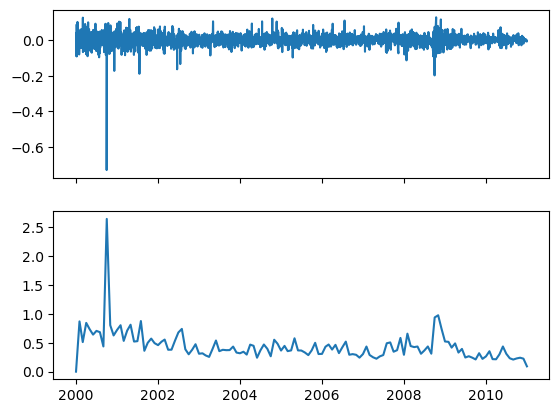

In [1]:
# Cambiando frecuencia
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

def realized_volatility(x):
    """Funcion para calcular la volatilidad realizada"""
    return np.sqrt(np.sum(x**2))

df = yf.download("AAPL",start="1999-12-31", end="2010-12-31", progress=False )

# Obteniendo una columna 
df = df.loc[:,["Adj Close"]]
df.rename(columns={"Adj Close":"adj_close"}, inplace=True)

# Calculo de rendimientos
df["log_rtn"] = np.log(df.adj_close/df.adj_close.shift(1))

# Calculo de la volatilidad realizada mensual
## Alternativa metodo resample
df_rv = df.groupby(pd.Grouper(freq="M")).apply(realized_volatility)
df_rv.rename(columns={"log_rtn":"rv"}, inplace=True)

# Anualizando los valores
df_rv.rv = df_rv.rv * np.sqrt(12)

# Graficando resultados
fig, ax = plt.subplots(2, 1, sharex=True) 
ax[0].plot(df.log_rtn)
ax[1].plot(df_rv.rv)

plt.show()


# Uso de resample

Normalmente, podríamos utilizar el método de remuestreo de un DataFrame de pandas. 

Suponiendo que quisiéramos calcular la media de la rentabilidad mensual, podríamos ejecutar `df.log_rtn.resample('M').mean()`. 

Para el método de remuestreo (resample), podemos utilizar cualquier función agregada incorporada en pandas, como `mean`, `sum`, `min`, `max` Sin embargo, nuestro caso es un poco más complejo, por lo que definimos una función de ayuda llamada realized_volatility, y replicamos el comportamiento de resample usando una combinación de `groupby`, `Grouper`, y `apply`

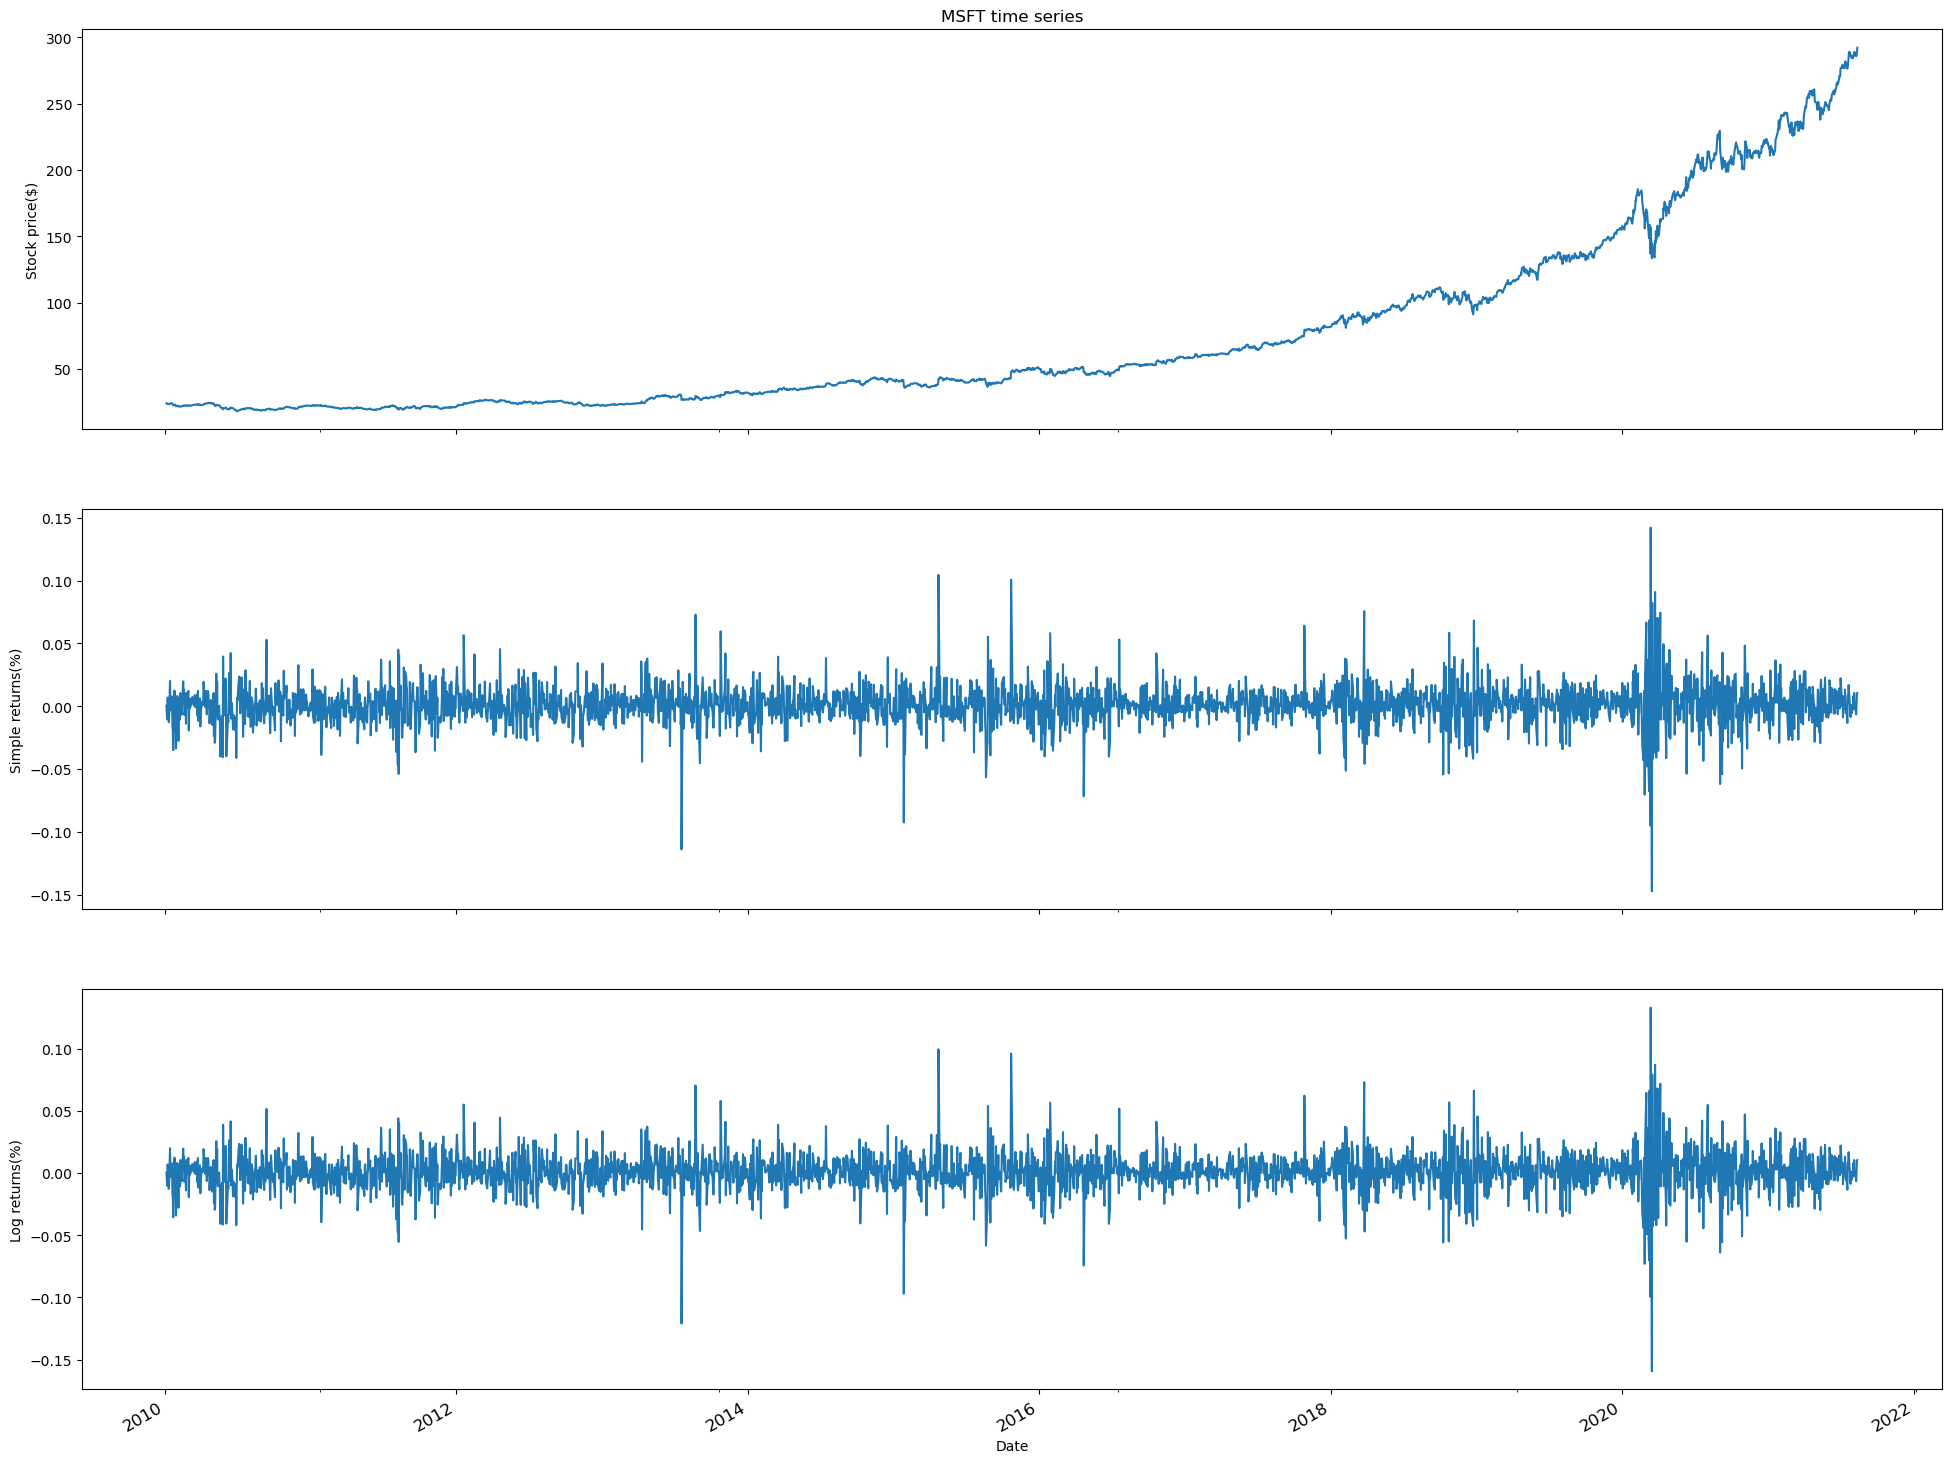

In [16]:
# Uso metodo plot de pandas
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

## Descarga de datos microsoft
df = yf.download("MSFT", start="2010-01-01", end="2021-08-14", progress=False)

## Obteniendo una columna -> cierre ajustado y renombrando columna
df = df.loc[:,["Adj Close"]]
df.rename(columns={"Adj Close":"adj_close"}, inplace=True)

## Calculo de retornos, usando los precios ajustados
df["simple_rtn"] = df.adj_close.pct_change()
df["log_rtn"] = np.log(df.adj_close/df.adj_close.shift(1))

# >> IMPORTANTE: ELIMINAR DATOS 'NA' 
df.dropna(how = 'any', inplace = True)

# método plot pandas

fig, ax = plt.subplots(3, 1, figsize=(24, 20), sharex=True)

## añadiendo precios
df.adj_close.plot(ax=ax[0])
ax[0].set(title="MSFT time series",
        ylabel = "Stock price($)")

## añadiendo retorno simples
df.simple_rtn.plot(ax=ax[1])
ax[1].set(ylabel="Simple returns(%)")

## añadiendo retornos logaritmicos
df.log_rtn.plot(ax=ax[2])
ax[2].set(xlabel="Date", ylabel="Log returns(%)")

ax[2].tick_params(axis='x', 
                  which='major', 
                  labelsize=12)

plt.show()


# Cufflinks
[Instalar biblioteca cufflinks](https://pypi.org/project/cufflinks/)

In [ ]:
# Configuracion ambiente de cufflinks
import cufflinks as cf
from plotly.offline import iplot, init_notebook_mode

# set up configuration (run it once)
cf.set_config_file(world_readable=True, theme="pearl", offline=True)
init_notebook_mode()


In [ ]:

import pandas as pd
import numpy as np
import yfinance as yf
import cufflinks as cf
from plotly.offline import iplot, init_notebook_mode
#import matplotlib.pyplot as plt


## Descarga de datos microsoft
df = yf.download("AAPL", start="2010-01-01", end="2021-08-14", progress=False)

## Obteniendo una columna -> cierre ajustado y renombrando columna
df = df.loc[:,["Adj Close"]]
df.rename(columns={"Adj Close":"adj_close"}, inplace=True)

## Calculo de retornos, usando los precios ajustados
df["simple_rtn"] = df.adj_close.pct_change()
df["log_rtn"] = np.log(df.adj_close/df.adj_close.shift(1))

## método plot cufflinks

df.iplot(subplots=True, shape=(3,1), shared_xaxes=True, title="AAPL time series")



## Otras librerias para crear graficos
Hay muchas más formas de crear gráficos en Python. Algunas de las bibliotecas: 
* matplotlib 
* seaborn 
* plotly 
* plotly_express 
* altair plotnine

# Tratamiento de valores atipicos
## Identificacion
Al trabajar con cualquier tipo de datos, a menudo nos encontramos con observaciones que son significativamente diferentes de la mayoría, es decir, valores atípicos. Pueden ser el resultado de un de un tick (precio) erróneo, de un acontecimiento importante en los mercados financieros, de un error en el procesamiento de datos, etc. Muchos algoritmos de aprendizaje automático y enfoques estadísticos pueden verse influenciados por los valores atípicos, dando lugar a resultados incorrectos o sesgados. Por eso debemos tratar los valores atípicos antes de crear cualquier modelo.

            adj_close  simple_rtn
Date                             
2010-08-02   8.017897         NaN
2010-08-03   8.020346    0.000305
2010-08-04   8.052494    0.004008
2010-08-05   8.013302   -0.004867
2010-08-06   7.964002   -0.006152


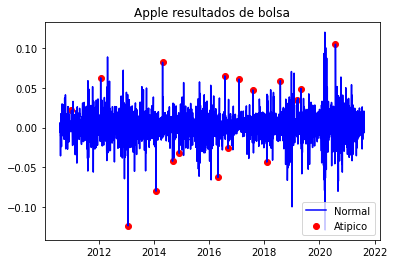

In [6]:
# Tratamiento de valores atipicos
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import numpy as np

## Definiendo funcion para detertar valores atipicos (outliers)
def indetify_outliers(row, n_sigmas=3):
    x = row["simple_rtn"]
    mu = row["mean"]
    sigma = row["std"]
    if (x > mu + 3 * sigma) or (x < mu - 3 * sigma):
        return 1
    else:
        return 0


## Descargando datos historicos apple
df = yf.download("AAPL", start="2010-08-01", end="2021-08-18", progress=False)

## Obteniendo una columna y renombrar
df = df.loc[:,["Adj Close"]]
df.rename(columns={"Adj Close":"adj_close"}, inplace=True)

## Calculo de los retornos
df["simple_rtn"] = df.adj_close.pct_change()
print(df.head())

# Calculo de la media movil y la desviacion estandar
df_rolling = df[["simple_rtn"]].rolling(window=21).agg(["mean","std"]) #ventana de 21 dias
df_rolling.columns = df_rolling.columns.droplevel()

# Ingresando las metricas moviles a los datos originales
df_outliers = df.join(df_rolling)

# Identificando los valores atipicos aplicando la funcion
df_outliers["outlier"] = df_outliers.apply(indetify_outliers, axis=1)
outliers = df_outliers.loc[df_outliers["outlier"]==1, ["simple_rtn"]]

# Graficando resultados
fig, ax = plt.subplots()
ax.plot(df_outliers.index, df_outliers.simple_rtn, color="blue", label="Normal")
ax.scatter(outliers.index, outliers.simple_rtn, color="red", label="Atipico")
ax.set_title("Apple resultados de bolsa")
ax.legend(loc="lower right")
plt.show()
